# TODO:
- check and add correct time scale
- +find method to visualize correlation -> distribution histogram
- try to use k-means clustering or other methods to cluster data
- try to understand or visualize the different levels comportement

# Correlation between the fission yeast transcriptome and proteome

In [252]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

from ipywidgets import IntSlider, interact

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [2]:
# set data path
path_data_mRNA = "data/pat1_average_modified.txt"
path_data_prot = "data/wtratioall.csv"

# read data from files
raw_data_mRNA = pd.read_csv(path_data_mRNA, sep='\t', header=None)
raw_data_prot = pd.read_csv(path_data_prot, index_col=0)

In [3]:
# preview of the raw mRNA data
raw_data_mRNA.head()

0          1                         2    3          4   \
0            aap1       AAP1  SPBC1652.02 SPBC16A3.20C  1.0  22.703531   
1  abc1: C2D10.18       ABC1               SPBC2D10.18  1.0   1.043491   
2  abc1: C9E9.12c       ABC1               SPAC9E9.12C  1.0   2.112546   
3            abp1  CBP1 ABP1              SPBC1105.04C  1.0   1.351277   
4            abp2       ABP2               SPBC1861.02  1.0   0.816301   

         5         6         7         8          9         10        11  \
0  0.960360  0.544460  0.896232  1.160251   1.252143  2.309153  2.310750   
1  0.622283  0.663191  0.619409  0.648403   0.662236  0.655953  0.580761   
2  0.906822  0.565746  0.535220  1.224398  10.170195  7.380023  4.455168   
3  0.884985  0.705397  0.401055  0.202862   0.175360  0.829920  0.959749   
4  1.969788  1.736116  1.057102  0.494822   0.372226  0.533438  0.851486   

         12        13        14  
0  2.449327  2.706837  3.064384  
1  0.606205  0.752322  0.798264  
2  2.804587  1.657471  1.310630  
3  1.121036  1.122949  1.103435  
4  0.989702  1.115665  1.159631

In [4]:
# preview of the raw protein data
raw_data_prot.head()

A_00      A_01      A_02      A_03      A_04      A_05  \
SPAC1002.02      1  1.451188  3.734827  6.181905  7.607555  5.215707   
SPAC1002.03c     1  0.922745  0.763064  0.749450  0.742595  0.771641   
SPAC1002.04c     1  1.063774  1.109541  1.105289  1.256196  1.193269   
SPAC1002.07c     1  0.946289  1.270676  1.577819  2.059521  2.079450   
SPAC1002.09c     1  0.909058  0.871595  0.907030  0.941867  0.963464   

                  A_06      A_07      A_08      A_09    ...         C_01  \
SPAC1002.02   3.439898  2.598756  2.183230  1.811290    ...     1.555395   
SPAC1002.03c  0.819817  0.859544  0.849914  0.838128    ...     0.901151   
SPAC1002.04c  0.834514  0.698355  0.714280  0.716728    ...     0.834014   
SPAC1002.07c  2.026755  1.934475  1.886784  1.820797    ...     1.145764   
SPAC1002.09c  0.963832  0.978117  1.026633  1.043288    ...     0.917147   

                  C_02      C_03      C_04      C_05      C_06      C_07  \
SPAC1002.02   3.676540  6.030714  6.635780  5.153358  3.210663  2.511956   
SPAC1002.03c  0.828585  0.779982  0.767321  0.813157  0.830826  0.875965   
SPAC1002.04c  0.829090  0.911089  1.179868  1.106116  0.824800  0.652223   
SPAC1002.07c  1.396319  1.819543  2.141494  2.219369  2.134959  2.000173   
SPAC1002.09c  0.879789  0.881237  0.897882  0.903383  0.907655  0.899867   

                  C_08      C_09      C_10  
SPAC1002.02   1.853247  1.525539  1.332680  
SPAC1002.03c  0.938763  0.819587  0.850455  
SPAC1002.04c  0.654474  0.618405  0.651751  
SPAC1002.07c  1.983480  1.959289  1.902660  
SPAC1002.09c  0.909359  0.945886  0.975173  

[5 rows x 33 columns]

## Processing raw data

### averaging and cleaning proteins data

In [5]:
# split protein data into 3 sets
data_prot_A = pd.DataFrame(raw_data_prot.ix[:,0:11].values)
data_prot_B = pd.DataFrame(raw_data_prot.ix[:,11:22].values)
data_prot_C = pd.DataFrame(raw_data_prot.ix[:,22:33].values)

# compute average of the 3 data sets
data_prot = (data_prot_A + data_prot_B + data_prot_C).copy()/3.0

# set columns and rows indexes
data_prot.columns = ['t'+str(k) for k in range(0,11)]
data_prot.index = raw_data_prot.index

# show begining of dataframe
data_prot.head()

t0        t1        t2        t3        t4        t5        t6  \
SPAC1002.02   1.0  1.393371  3.257203  5.591645  6.932151  5.479337  3.574659   
SPAC1002.03c  1.0  0.910152  0.785974  0.750362  0.746000  0.770242  0.800074   
SPAC1002.04c  1.0  0.990121  0.980455  1.050549  1.248047  1.217455  0.880529   
SPAC1002.07c  1.0  1.046894  1.307253  1.640936  2.070811  2.125540  2.078482   
SPAC1002.09c  1.0  0.904997  0.855320  0.872414  0.904201  0.923575  0.932110   

                    t7        t8        t9       t10  
SPAC1002.02   2.726113  2.114409  1.764191  1.439884  
SPAC1002.03c  0.843706  0.872157  0.819914  0.839864  
SPAC1002.04c  0.704999  0.712103  0.701598  0.795477  
SPAC1002.07c  1.997900  1.900363  1.857979  1.780422  
SPAC1002.09c  0.939830  0.961271  0.991512  1.018891

### cleaning mRNA data

In [6]:
# remove first 2 columns (TODO: need to check if it removes useful names)
data_mRNA = raw_data_mRNA.drop([0,1], axis=1).copy()

# set columns indexes
data_mRNA.set_index([2], inplace=True)
data_mRNA.index.name = None
data_mRNA.columns = ['t'+str(k) for k in range(0,12)]

# drop data without values
data_mRNA.dropna(how='any', inplace=True)

# show begining of dataframe
data_mRNA.head()

t0         t1        t2        t3        t4  \
SPBC1652.02 SPBC16A3.20C  1.0  22.703531  0.960360  0.544460  0.896232   
SPBC2D10.18               1.0   1.043491  0.622283  0.663191  0.619409   
SPAC9E9.12C               1.0   2.112546  0.906822  0.565746  0.535220   
SPBC1105.04C              1.0   1.351277  0.884985  0.705397  0.401055   
SPBC1861.02               1.0   0.816301  1.969788  1.736116  1.057102   

                                t5         t6        t7        t8        t9  \
SPBC1652.02 SPBC16A3.20C  1.160251   1.252143  2.309153  2.310750  2.449327   
SPBC2D10.18               0.648403   0.662236  0.655953  0.580761  0.606205   
SPAC9E9.12C               1.224398  10.170195  7.380023  4.455168  2.804587   
SPBC1105.04C              0.202862   0.175360  0.829920  0.959749  1.121036   
SPBC1861.02               0.494822   0.372226  0.533438  0.851486  0.989702   

                               t10       t11  
SPBC1652.02 SPBC16A3.20C  2.706837  3.064384  
SPBC2D10.18               0.752322  0.798264  
SPAC9E9.12C               1.657471  1.310630  
SPBC1105.04C              1.122949  1.103435  
SPBC1861.02               1.115665  1.159631

Some of the values in mRNA are duplicates and need to be dealt with

In [7]:
duplicated_data_mRNA = raw_data_mRNA[raw_data_mRNA[[2]].isin(data_mRNA[data_mRNA.index.duplicated()].index).values].copy()
duplicated_data_mRNA = duplicated_data_mRNA.sort_values([2])

# save duplicated mRNA data
duplicated_data_mRNA.to_csv('data/duplicated_mRNA.csv')

# show preview
duplicated_data_mRNA.head()

0           1             2    3         4         5   \
507       C13G7.02c.B         NaN  SPAC13G7.02C  1.0  0.480851  1.821550   
506       C13G7.02c.A         NaN  SPAC13G7.02C  1.0  1.139014  5.825920   
505         C13G7.02c         NaN  SPAC13G7.02C  NaN       NaN       NaN   
10        ade2: min10  ADE2 MIN10    SPAC144.03  1.0  0.597784  0.552436   
3819  I21_ade2: min10  ADE2 MIN10    SPAC144.03  1.0  1.247429  2.754731   

            6          7          8          9         10        11        12  \
507   2.200407   2.647362   3.204608   2.962069  0.816963  0.817025  0.790903   
506   7.595293  19.737550  24.382723  27.602160  7.971517  6.919817  9.305873   
505        NaN        NaN        NaN        NaN       NaN       NaN       NaN   
10    0.423964   0.333494   0.287265   0.176862  0.230313  0.223476  0.261122   
3819  2.002274   1.818740   1.673060   2.102656  2.313404  2.398567  3.019608   

             13         14  
507    1.049258   1.244611  
506   12.082448  14.460800  
505         NaN        NaN  
10     0.277014   0.331003  
3819   3.698596   3.454753

We have some duplicated mRNA data which will be removed during the merging phase.

## Filtering data

Extracting data with common index between the protein and mRNA data

In [8]:
# create the pattern and the filter
pattern = '|'.join(data_prot.index.values)
filter_ = data_mRNA.index.str.contains(pattern, case=False, na=False)

# extract mRNA data with corresponding protein name
data_mRNA = data_mRNA[filter_]

# show preview
data_mRNA.head()

t0        t1        t2        t3        t4        t5        t6  \
SPBC2D10.18   1.0  1.043491  0.622283  0.663191  0.619409  0.648403  0.662236   
SPBC1105.04C  1.0  1.351277  0.884985  0.705397  0.401055  0.202862  0.175360   
SPBC32H8.12C  1.0  0.621846  0.325697  0.390388  0.419048  0.435039  0.539601   
SPAC630.03    1.0  0.945575  0.576106  0.698916  0.638058  0.423130  0.352959   
SPBC106.04    1.0  0.871751  0.869876  1.023361  0.727945  0.261486  0.143920   

                    t7        t8        t9       t10       t11  
SPBC2D10.18   0.655953  0.580761  0.606205  0.752322  0.798264  
SPBC1105.04C  0.829920  0.959749  1.121036  1.122949  1.103435  
SPBC32H8.12C  0.403898  0.337072  0.281851  0.265122  0.281973  
SPAC630.03    0.746192  0.829190  0.843786  0.889201  0.842393  
SPBC106.04    0.437443  0.805628  0.984534  0.974699  1.019219

In [9]:
# comparing size of protein data and filtered mRNA data
print('Size of the protein data:', data_prot.shape)
print('Size of the filtered mRNA data:', data_mRNA.shape)
print('Lost entries:', data_prot.shape[0]-data_mRNA.shape[0])

Size of the protein data: (2969, 11)
Size of the filtered mRNA data: (2874, 12)
Lost entries: 95


We lost 95 entries in the protein data which are not in the mRNA data or with unavailable data. 5 entries might correspond to the last 5 entries of the protein data. The others come from the non available data in the mRNA data.

## Merging the mRNA and protein data sets

In [10]:
# get list of indexes and names to sort and finalizing mergin of the two data frames
idxname = np.array([], dtype=int)
listname = np.array([], dtype=object)
for name in data_prot.index.values:
    filter_ = data_mRNA.index.str.contains(name, case=False, na=False)
    
    if len(data_mRNA[filter_].index)==1:
        idxname = np.append(idxname, data_mRNA.index.get_loc(data_mRNA[filter_].index[0]))
        listname = np.append(listname, name)

In [11]:
# sorting data and removing duplicated keys for the mRNA data
data_mRNA_sorted = data_mRNA.iloc[list(idxname)]
data_mRNA_sorted.set_index([listname.tolist()], inplace=True)
data_mRNA_sorted.head()

t0        t1        t2        t3        t4        t5        t6  \
SPAC1002.02   1.0  1.035300  2.905877  4.153496  4.783120  2.603015  1.647060   
SPAC1002.03c  1.0  0.958027  0.676712  0.703215  0.747138  0.861940  1.257074   
SPAC1002.04c  1.0  1.133477  1.140642  1.189899  1.622498  2.308321  3.020603   
SPAC1002.07c  1.0  0.783431  1.362667  1.602399  1.836938  1.938045  1.969526   
SPAC1002.09c  1.0  0.728322  0.701878  1.354810  1.140213  0.637736  0.368306   

                    t7        t8        t9       t10       t11  
SPAC1002.02   1.481230  1.616345  1.347246  1.122512  1.064692  
SPAC1002.03c  1.235414  0.950157  0.988842  1.161624  1.166776  
SPAC1002.04c  1.853997  1.714919  1.682955  1.530989  1.539161  
SPAC1002.07c  0.570085  0.593492  0.524142  0.437590  0.482167  
SPAC1002.09c  0.276762  0.236933  0.258554  0.260154  0.297513

In [12]:
# removing non existant keys in protein data
data_prot_filtered = data_prot.loc[listname]
data_prot_filtered.head()

t0        t1        t2        t3        t4        t5        t6  \
SPAC1002.02   1.0  1.393371  3.257203  5.591645  6.932151  5.479337  3.574659   
SPAC1002.03c  1.0  0.910152  0.785974  0.750362  0.746000  0.770242  0.800074   
SPAC1002.04c  1.0  0.990121  0.980455  1.050549  1.248047  1.217455  0.880529   
SPAC1002.07c  1.0  1.046894  1.307253  1.640936  2.070811  2.125540  2.078482   
SPAC1002.09c  1.0  0.904997  0.855320  0.872414  0.904201  0.923575  0.932110   

                    t7        t8        t9       t10  
SPAC1002.02   2.726113  2.114409  1.764191  1.439884  
SPAC1002.03c  0.843706  0.872157  0.819914  0.839864  
SPAC1002.04c  0.704999  0.712103  0.701598  0.795477  
SPAC1002.07c  1.997900  1.900363  1.857979  1.780422  
SPAC1002.09c  0.939830  0.961271  0.991512  1.018891

In [13]:
print('Size of the filtered protein data:', data_prot_filtered.shape)
print('Size of the filtered and sorted mRNA data:', data_mRNA_sorted.shape)
print('Lost entries:', data_prot.shape[0]-data_prot_filtered.shape[0])

Size of the filtered protein data: (2816, 11)
Size of the filtered and sorted mRNA data: (2816, 12)
Lost entries: 153


We go from 95 lost entries to 153 lost entries when removing the duplicates.

Joining the two tables

In [299]:
data = data_prot_filtered.join(data_mRNA_sorted, lsuffix='p', rsuffix='m')
print('Size of joined data:', data.shape)
data.head()

Size of joined data: (2816, 23)


t0p       t1p       t2p       t3p       t4p       t5p       t6p  \
SPAC1002.02   1.0  1.393371  3.257203  5.591645  6.932151  5.479337  3.574659   
SPAC1002.03c  1.0  0.910152  0.785974  0.750362  0.746000  0.770242  0.800074   
SPAC1002.04c  1.0  0.990121  0.980455  1.050549  1.248047  1.217455  0.880529   
SPAC1002.07c  1.0  1.046894  1.307253  1.640936  2.070811  2.125540  2.078482   
SPAC1002.09c  1.0  0.904997  0.855320  0.872414  0.904201  0.923575  0.932110   

                   t7p       t8p       t9p    ...          t2m       t3m  \
SPAC1002.02   2.726113  2.114409  1.764191    ...     2.905877  4.153496   
SPAC1002.03c  0.843706  0.872157  0.819914    ...     0.676712  0.703215   
SPAC1002.04c  0.704999  0.712103  0.701598    ...     1.140642  1.189899   
SPAC1002.07c  1.997900  1.900363  1.857979    ...     1.362667  1.602399   
SPAC1002.09c  0.939830  0.961271  0.991512    ...     0.701878  1.354810   

                   t4m       t5m       t6m       t7m       t8m       t9m  \
SPAC1002.02   4.783120  2.603015  1.647060  1.481230  1.616345  1.347246   
SPAC1002.03c  0.747138  0.861940  1.257074  1.235414  0.950157  0.988842   
SPAC1002.04c  1.622498  2.308321  3.020603  1.853997  1.714919  1.682955   
SPAC1002.07c  1.836938  1.938045  1.969526  0.570085  0.593492  0.524142   
SPAC1002.09c  1.140213  0.637736  0.368306  0.276762  0.236933  0.258554   

                  t10m       t11  
SPAC1002.02   1.122512  1.064692  
SPAC1002.03c  1.161624  1.166776  
SPAC1002.04c  1.530989  1.539161  
SPAC1002.07c  0.437590  0.482167  
SPAC1002.09c  0.260154  0.297513  

[5 rows x 23 columns]

### Standardizing data

Defining standardizing function (return z-score)

In [15]:
def standardize(df):
    return df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)

Renaming tables for easier use and standardizing them (remplacing with z-score)

In [16]:
prot_data = standardize(data_prot_filtered)
mRNA_data = standardize(data_mRNA_sorted.drop('t11', axis=1))
# TODO: check time scale

# Plots

The standardized ratio for the protein 'SPAC1002.02' and the correspond mRNA looks correlated

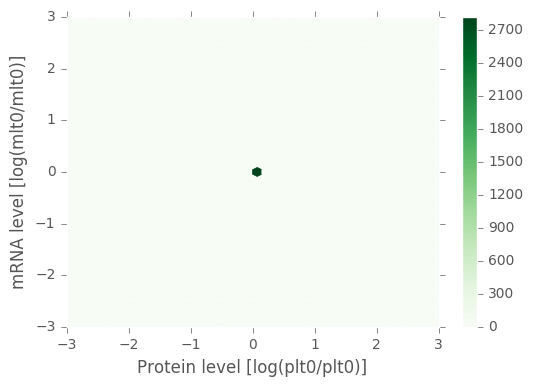

<function __main__.plot_relation>

In [17]:
x_min = -3
x_max = 3
y_min = -3
y_max = 3
nbins = 40

def plot_relation(t):
    fig, ax = plt.subplots()
    hx = ax.hexbin(np.log(data)['t'+str(t)+'p'], np.log(data)['t'+str(t)+'m'], cmap='Greens', gridsize=nbins, extent=[x_min, x_max, y_min, y_max])
    fig.colorbar(hx)
    plt.xlabel('Protein level [log(plt'+str(t)+'/plt0)]')
    plt.ylabel('mRNA level [log(mlt'+str(t)+'/mlt0)]')
    plt.show()
    
interact(plot_relation, t=IntSlider(min=0, max=10))

The action-reaction between mRNA and protein can be observed when looking at time *t = 1* and *t = 2*. At *t = 1*, the mRNA spreads and the stay small as if they are uncorrelated. At *t = 2*, the proteins level responds and we can see that the protein and mRNA levels are correlated. We can also see that correlation until time *t = 7*. After time *t = 6*, the data looks uncorrelated for some reason.

Definition of another useful plot function

In [18]:
def plot_set(k):
    if type(k) == int:
        plt.plot(prot_data.iloc[k].values, label='Protein')
        plt.plot(mRNA_data.iloc[k].values, label='mRNA')
        plt.title(prot_data.index[k])
    elif type(k) == str:
        plt.plot(prot_data.loc[k].values, label='Protein')
        plt.plot(mRNA_data.loc[k].values, label='mRNA')
        plt.title(k)
    else:
        raise NameError('unrecognize input type '+str(type(k)))
    
    plt.xlabel('Time []')
    plt.ylabel('Standardized ratio')
    
    plt.legend()
    plt.show()

# Correlations

## Considering only 'SPAC1002.02'

Let's look at the correlation for the first protein in our dataframe. First, we plot the entries for the first mRNA and protein for each time points.

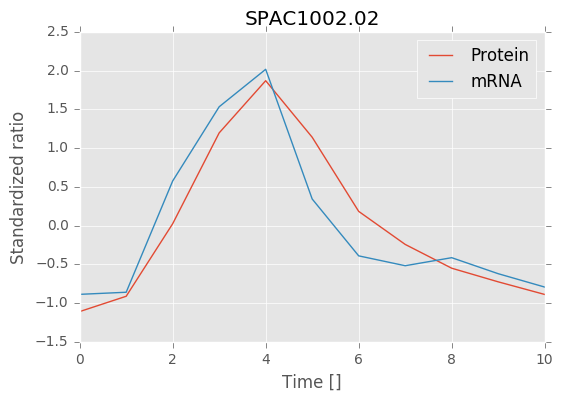

In [19]:
plot_set(0)

The two curves are similare so we might say that they are correlated. The quantification of the correlation between the standardized ratio of the protein 'SPAC1002.02' and the correspond mRNA can be done using Pearson's correlation :

$$ \text{corr}(X,Y) = \dfrac{\text{cov}(X,Y)}{\sigma_X \sigma_Y} $$

In [20]:
def compute_corr(k):
    return prot_data.iloc[k].corr(mRNA_data.iloc[k], method='pearson')

print('correlation :', compute_corr(0))

correlation : 0.921495693413


The Pearson correlation values are between *-1* and *1*. A correlation of *0* means that they are **uncorrelated**, *-1* **anticorrelated** and *1* **correlated**. So as expected the mRNA levels and protein levels for 'SPAC1002.02' are correlated in time.

## Considering all mRNA and proteins pairs

Let's compute the correlation for all protein and mRNA pairs

In [21]:
correl = np.zeros((data.shape[0],))
for k in range(data.shape[0]):
    correl[k] = compute_corr(k)

corr_ = pd.Series(correl, index=data.index)

### Correlation distribution

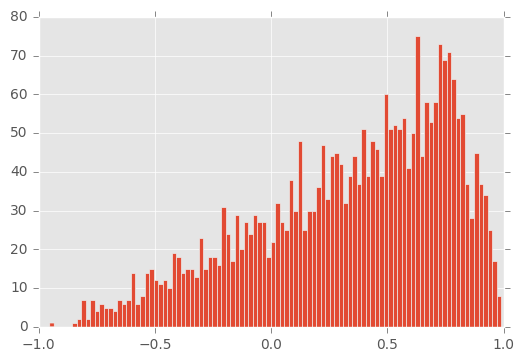

In [22]:
corr_.hist(bins=100)
plt.show()

### Most correlated

In [23]:
corr_.sort_values().tail()

SPBC27.03       0.973395
SPAC23H3.15c    0.974109
SPAC637.06      0.975517
SPACUNK4.17     0.977701
SPAC11D3.01c    0.988610
dtype: float64

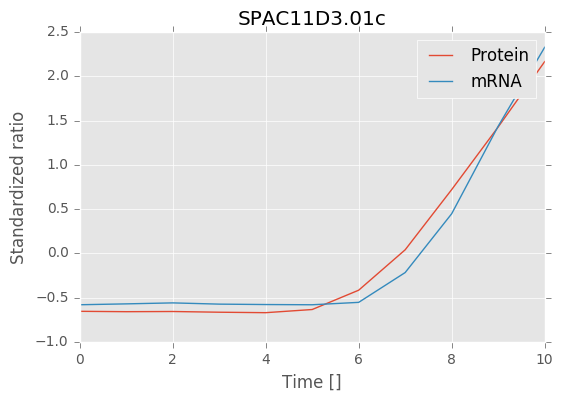

In [24]:
plot_set('SPAC11D3.01c')

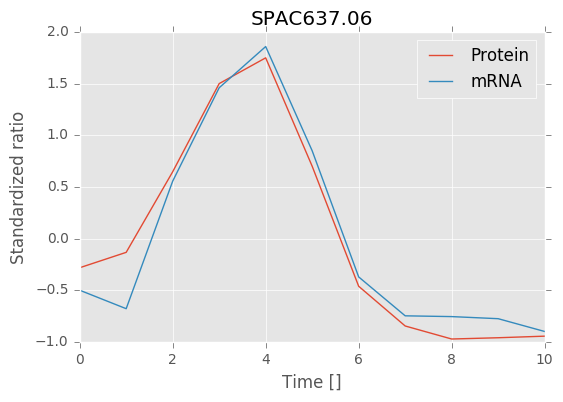

In [25]:
plot_set('SPAC637.06')

### Most anticorrelated

In [26]:
corr_.sort_values().head()

SPCC1682.01    -0.952655
SPAC3A12.11c   -0.842990
SPCC18.18c     -0.833734
SPCP1E11.07c   -0.820946
SPAC27F1.02c   -0.815169
dtype: float64

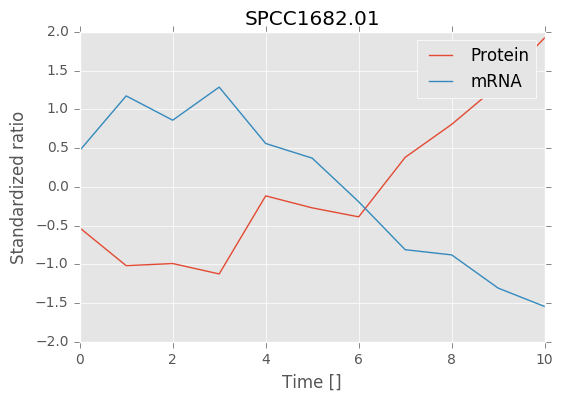

In [27]:
plot_set('SPCC1682.01')

### Most not correlated

In [28]:
sym_thr = 0.005
corr_[(-sym_thr<corr_) & (corr_<sym_thr)]

SPAC144.16      -0.004633
SPAC20H4.03c    -0.000004
SPAC3H8.07c     -0.000511
SPBC19C2.13c     0.002180
SPBC20F10.02c    0.002289
SPBC887.10       0.002604
SPCC11E10.02c   -0.003537
dtype: float64

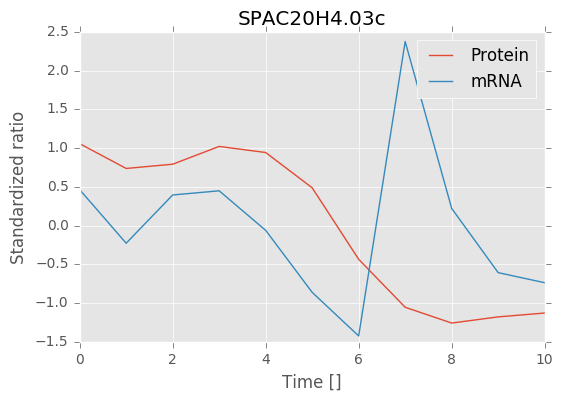

In [29]:
plot_set('SPAC20H4.03c')

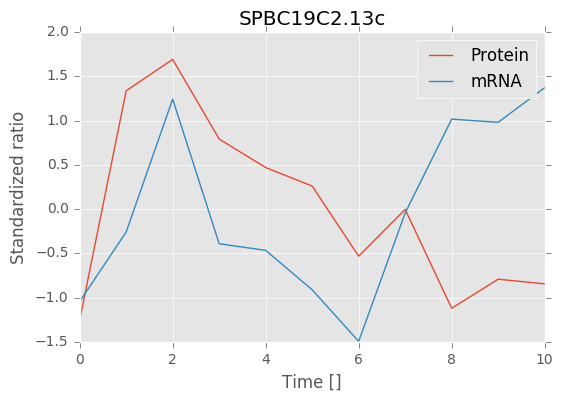

In [30]:
plot_set('SPBC19C2.13c')

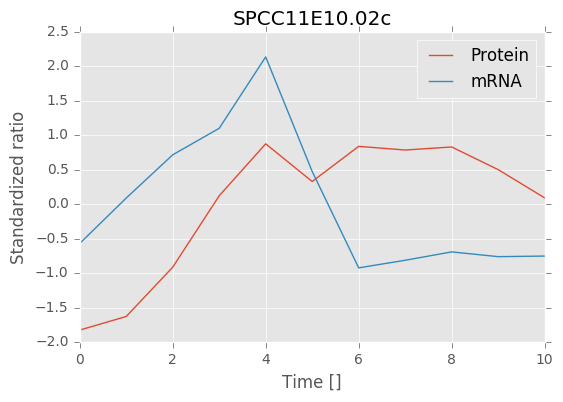

In [31]:
plot_set('SPCC11E10.02c')

### Heatmap of correlation between all possible pair of stages

http://seaborn.pydata.org/generated/seaborn.heatmap.html

In [32]:
def plot_heatmap(df):
    mask_ = np.triu(np.ones(df.shape, dtype=bool),k=1) 
    ax = sns.heatmap(df, annot=True, fmt=".1f", linewidths=0.5, cbar=False, square=True, mask=mask_)
    ax.set_axis_bgcolor('None')
    return ax

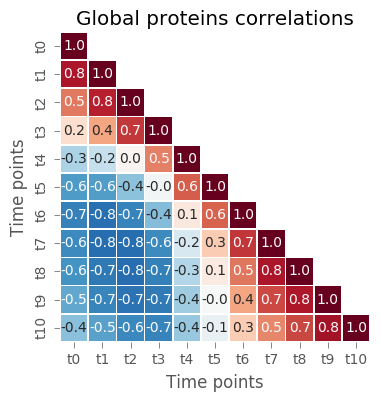

In [33]:
ax = plot_heatmap(prot_data.corr())
ax.set_title('Global proteins correlations')
ax.set_xlabel('Time points')
ax.set_ylabel('Time points')
plt.show()

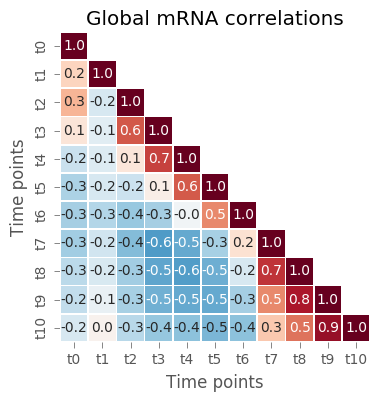

In [34]:
ax = plot_heatmap(mRNA_data.corr())
ax.set_title('Global mRNA correlations')
ax.set_xlabel('Time points')
ax.set_ylabel('Time points')
plt.show()

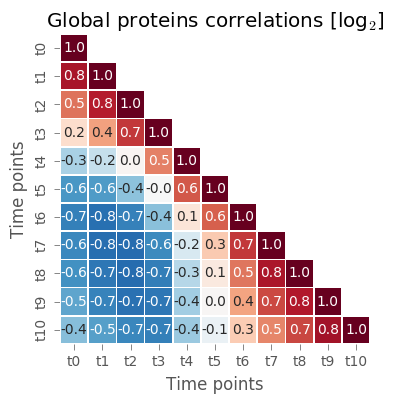

In [35]:
ax = plot_heatmap(standardize(np.log2(data_prot_filtered)).corr())
ax.set_title('Global proteins correlations [log$_2$]')
ax.set_xlabel('Time points')
ax.set_ylabel('Time points')
plt.show()

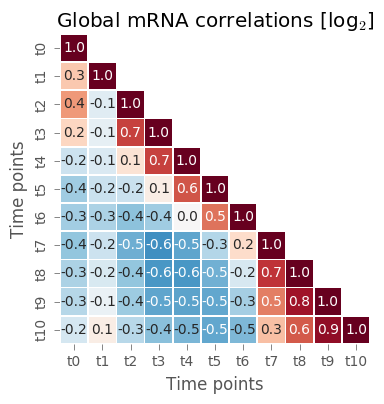

In [36]:
ax = plot_heatmap(standardize(np.log2(data_mRNA_sorted).drop('t11', axis=1)).corr())
ax.set_title('Global mRNA correlations [log$_2$]')
ax.set_xlabel('Time points')
ax.set_ylabel('Time points')
plt.show()

# k-means clustering

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [166]:
def kmeans(df, k):
    kmeans_model = KMeans(n_clusters=k)
    model = kmeans_model.fit(df)
    score = silhouette_score(df, model.labels_)
    return model, score

In [167]:
def plot_kmeans_centers(model, n_clust):
    for k in range(n_clust):
        plt.plot(model.cluster_centers_[k,:], label='c$_'+str(k)+'$')
    
    plt.legend(loc='best')

In [258]:
def plot_clust(model, df1, df2, l):
    plt.plot(np.arange(11), df1.iloc[np.where(model.labels_==l)].values.T, color=(1.0,0.0,0.0,0.1))
    plt.plot(np.arange(11), df2.iloc[np.where(model.labels_==l)].values.T, color=(0.0,0.0,1.0,0.1))
    
    red = mpatches.Patch(color='red', label='prot')
    blue = mpatches.Patch(color='blue', label='mRNA')
    plt.legend(handles=[red,blue], loc='best')

## Proteins clustering

silhouette score = 0.382667956878


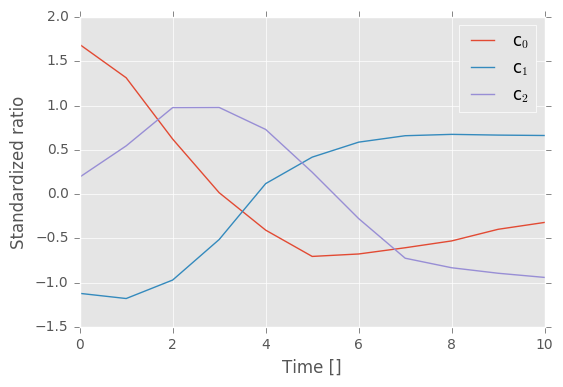

In [228]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 3
prot_model, prot_score = kmeans(prot_data, n_clust)

# Display results of k-means
print('silhouette score =', prot_score)
plot_kmeans_centers(prot_model, n_clust)
plt.xlabel('Time []')
plt.ylabel('Standardized ratio')
plt.show()

## mRNA clustering

silhouette score = 0.280706989653


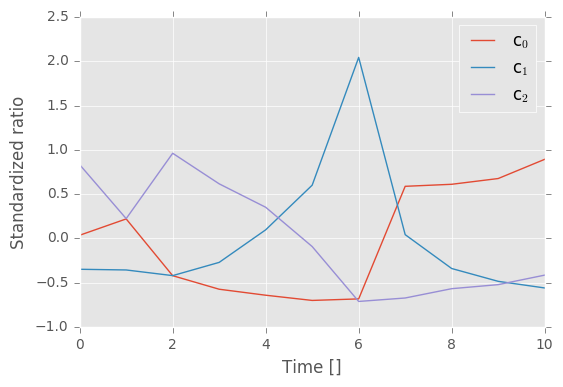

In [229]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 3
mRNA_model, mRNA_score = kmeans(mRNA_data, n_clust)

# Display results of k-means
print('silhouette score =', mRNA_score)
plot_kmeans_centers(mRNA_model, n_clust)
plt.xlabel('Time []')
plt.ylabel('Standardized ratio')
plt.show()

## Trying relative distance clustering

In [253]:
# Compute relative distance
rel_dist_data = (mRNA_data - prot_data).copy()

silhouette score = 0.17143085646


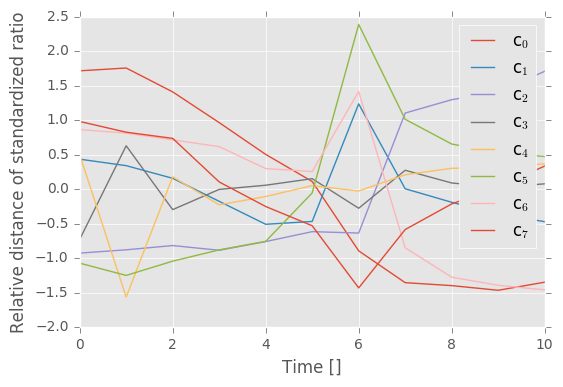

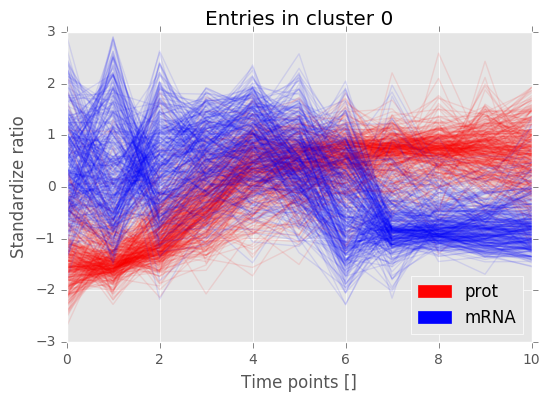

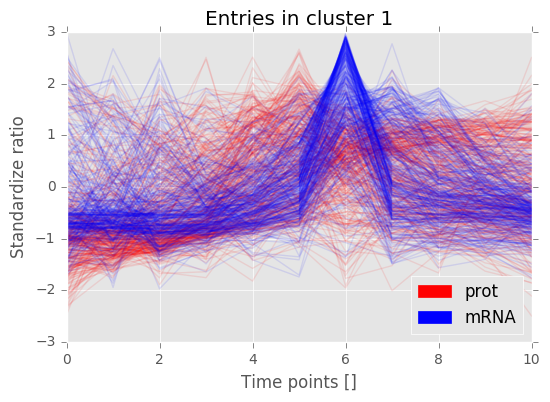

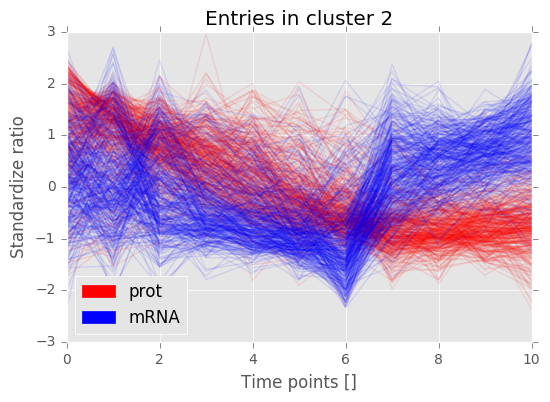

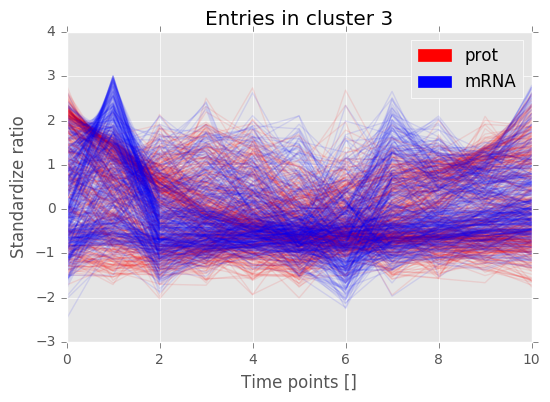

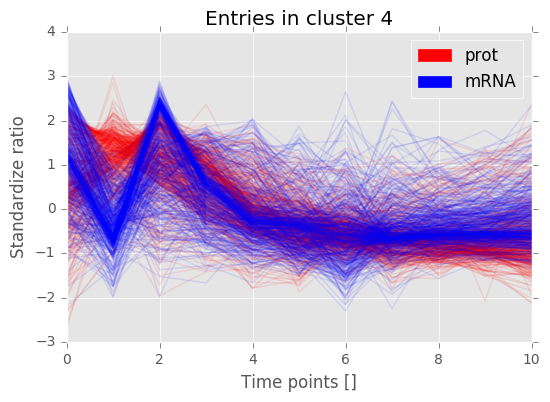

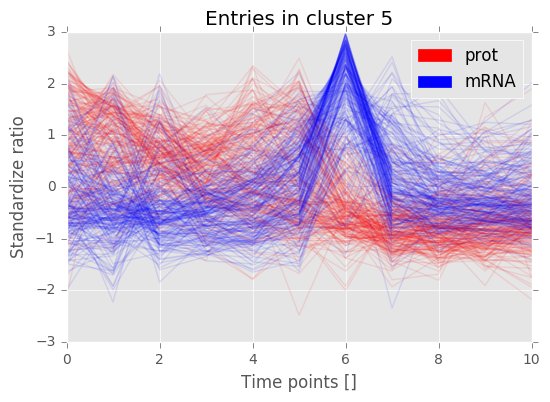

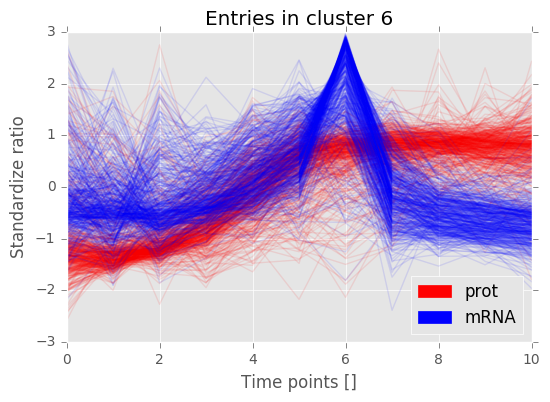

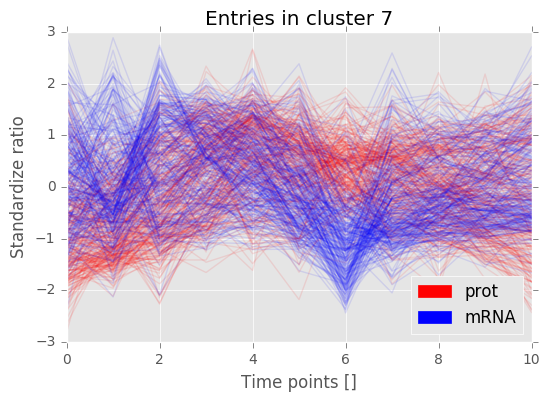

In [260]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 8
rel_dist_model, rel_dist_score = kmeans(rel_dist_data, n_clust)

# Display results of k-means
print('silhouette score =', rel_dist_score)
plot_kmeans_centers(rel_dist_model, n_clust)
plt.xlabel('Time []')
plt.ylabel('Relative distance of standardized ratio')
plt.show()

for l in range(n_clust):
    plot_clust(rel_dist_model, prot_data, mRNA_data, l)
    plt.title('Entries in cluster '+str(l))
    plt.ylabel('Standardize ratio')
    plt.xlabel('Time points []')
    plt.show()

## Clustering using whole data

In [310]:
# drop t11 data point for all mRNA (not really necessary)
data_set = prot_data.join(mRNA_data, lsuffix='p', rsuffix='m')
data_set.head()

t0p       t1p       t2p       t3p       t4p       t5p  \
SPAC1002.02  -1.108120 -0.910578  0.025395  1.197697  1.870868  1.141299   
SPAC1002.03c  2.235950  1.048852 -0.591830 -1.062347 -1.119982 -0.799684   
SPAC1002.04c  0.335174  0.284492  0.234906  0.594501  1.607708  1.450762   
SPAC1002.07c -1.723581 -1.609692 -0.977374 -0.166977  0.877037  1.009952   
SPAC1002.09c  1.208769 -0.606498 -1.555693 -1.229074 -0.621706 -0.251516   

                   t6p       t7p       t8p       t9p    ...          t1m  \
SPAC1002.02   0.184814 -0.241306 -0.548489 -0.724361    ...    -0.858747   
SPAC1002.03c -0.405531  0.170943  0.546855 -0.143408    ...    -0.000832   
SPAC1002.04c -0.277736 -1.178242 -1.141798 -1.195694    ...    -0.876260   
SPAC1002.07c  0.895667  0.699961  0.463080  0.360143    ...    -0.596577   
SPAC1002.09c -0.088437  0.059075  0.468761  1.046583    ...     0.241196   

                   t2m       t3m       t4m       t5m       t6m       t7m  \
SPAC1002.02   0.577023  1.534638  2.017909  0.344560 -0.389188 -0.516472   
SPAC1002.03c -1.392913 -1.261765 -1.044411 -0.476315  1.479000  1.371813   
SPAC1002.04c -0.864208 -0.781349 -0.053650  1.100015  2.298185  0.335769   
SPAC1002.07c  0.353574  0.746818  1.131546  1.297397  1.349038 -0.946540   
SPAC1002.09c  0.174242  1.827431  1.284083  0.011838 -0.670345 -0.902130   

                   t8m       t9m      t10m  
SPAC1002.02  -0.412763 -0.619312 -0.791807  
SPAC1002.03c -0.039776  0.151657  1.006668  
SPAC1002.04c  0.101818  0.048050 -0.207582  
SPAC1002.07c -0.908146 -1.021904 -1.163878  
SPAC1002.09c -1.002974 -0.948231 -0.944180  

[5 rows x 22 columns]

silhouette score = 0.168958957339


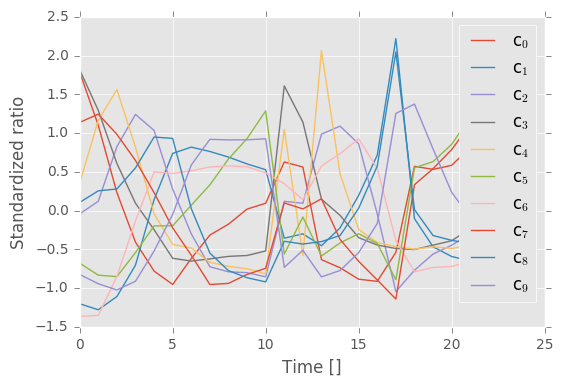

In [316]:
# Use k-means clustering with 'n_clust' clusters
n_clust = 10
set_model, set_score = kmeans(data_set, n_clust)

# Display results of k-means
print('silhouette score =', set_score)
plot_kmeans_centers(set_model, n_clust)
plt.xlabel('Time []')
plt.ylabel('Standardized ratio')
plt.show()
# TODO : change graph or rename graph !!

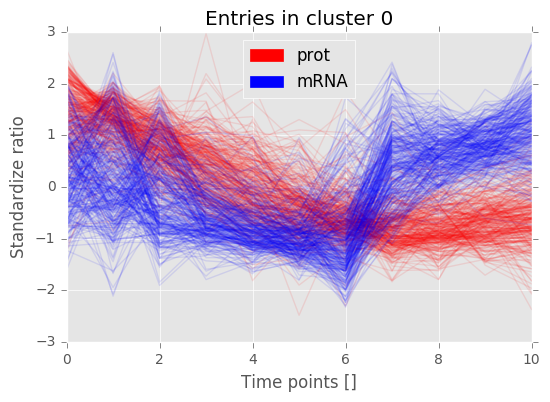

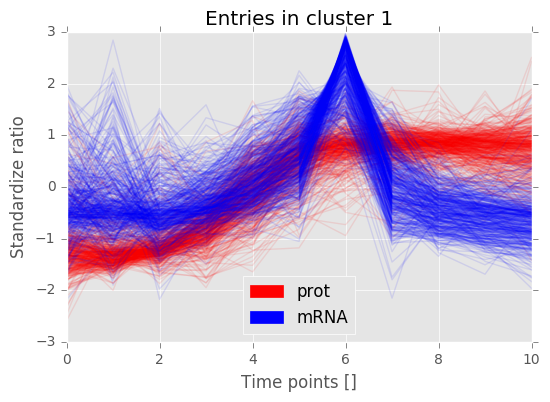

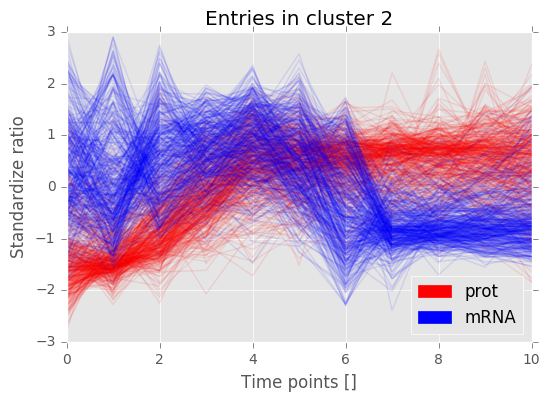

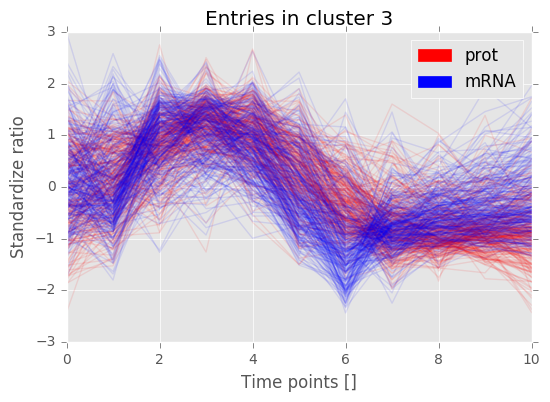

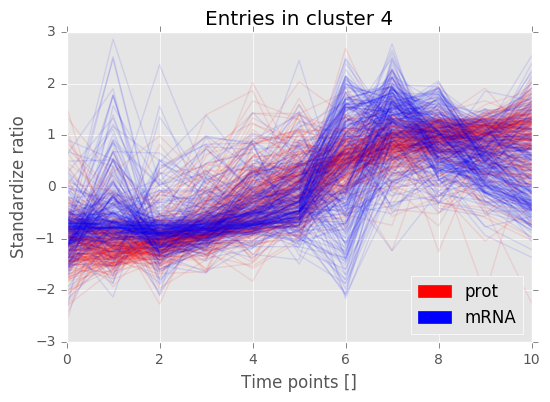

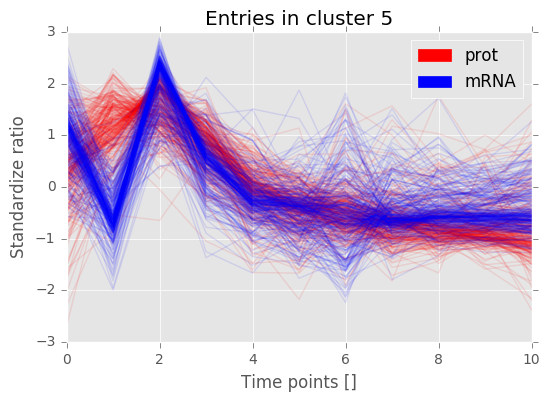

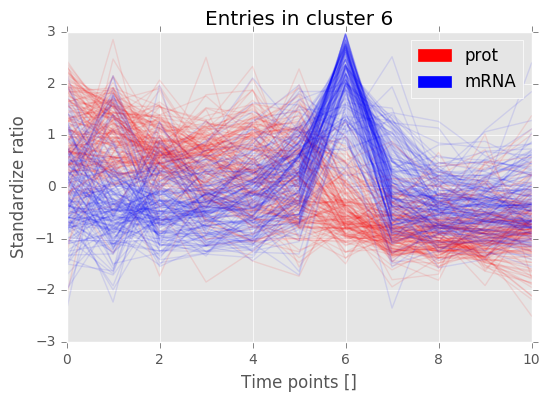

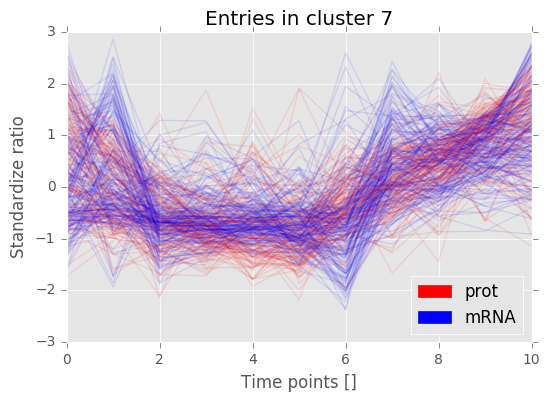

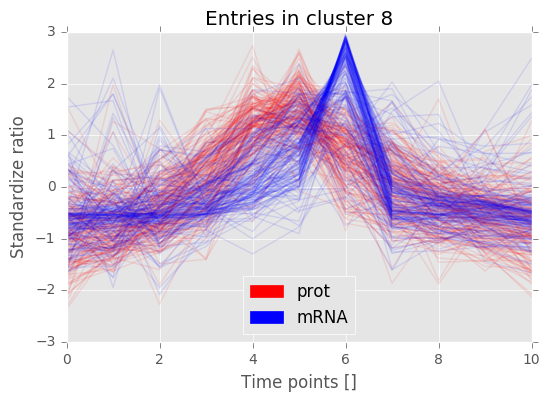

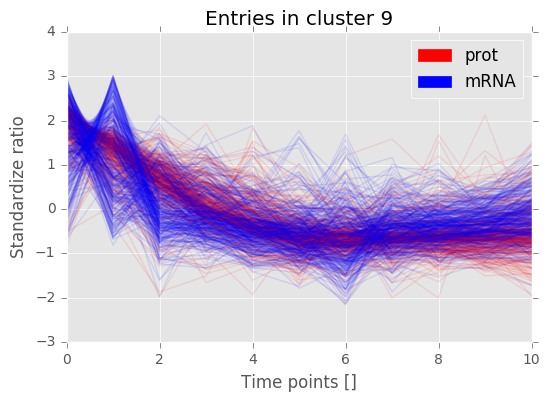

In [314]:
for l in range(n_clust):
    plot_clust(set_model, prot_data, mRNA_data, l)
    plt.title('Entries in cluster '+str(l))
    plt.ylabel('Standardize ratio')
    plt.xlabel('Time points []')
    plt.show()